In [40]:
!pip install tensorflow opencv-python

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [41]:
import zipfile
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("data")
import os
os.listdir("data")


['TrashType_Image_Dataset', 'modified-dataset']

In [42]:
IMG_SIZE = 128
data_path = 'data/TrashType_Image_Dataset'  # Adjust if needed

categories = sorted(os.listdir(data_path))
label_map = {cat: i for i, cat in enumerate(categories)}

X, y = [], []

for cat in categories:
    cat_path = os.path.join(data_path, cat)
    for img_name in os.listdir(cat_path):
        img_path = os.path.join(cat_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = preprocess_input(img)
            X.append(img)
            y.append(label_map[cat])

X = np.array(X)
y = to_categorical(np.array(y))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)


In [54]:
train_aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_aug = ImageDataGenerator()


In [55]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the pre-trained part

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [45]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history = model.fit(
    train_aug.flow(X_train, y_train, batch_size=32),
    validation_data=val_aug.flow(X_val, y_val),
    epochs=30,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.2492 - loss: 2.2544

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 361ms/step - accuracy: 0.2496 - loss: 2.2516 - val_accuracy: 0.5217 - val_loss: 1.3209 - learning_rate: 1.0000e-04
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - accuracy: 0.3812 - loss: 1.6777 - val_accuracy: 0.5988 - val_loss: 1.1034 - learning_rate: 1.0000e-04
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.4374 - loss: 1.4607 - val_accuracy: 0.6522 - val_loss: 0.9800 - learning_rate: 1.0000e-04
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 0.5125 - loss: 1.2531 - val_accuracy: 0.6897 - val_loss: 0.9059 - learning_rate: 1.0000e-04
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 390ms/step - accuracy: 0.5457 - loss: 1.2098 - val_accuracy: 0.7115 - val_loss: 0.8454 - learning_rate: 1.0000e-04
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - accuracy: 0.5773 - loss: 1.1193 - val_accuracy: 0.7075 - val_loss: 0.8088 - learning_rate: 1.0000e-04
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 334ms/step - accuracy: 0.58

In [46]:
model.save('trash_classifier.h5')
print("✅ Model saved as trash_classifier.h5")


✅ Model saved as trash_classifier.h5


In [56]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import cv2
import os

# Load the trained model
model = load_model("trash_classifier.h5")

# Define label map (update based on your dataset)
categories = sorted(os.listdir("data/TrashType_Image_Dataset"))
label_map = {i: cat for i, cat in enumerate(categories)}


In [57]:
def predict_image(img_path):
    IMG_SIZE = 128

    img = cv2.imread(img_path)
    if img is None:
        print("⚠️ Error: Image not found at path:", img_path)
        return None

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = preprocess_input(img)  # Normalize using MobileNetV2 preprocessing
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    class_index = np.argmax(prediction)
    class_label = label_map[class_index]
    confidence = round(np.max(prediction) * 100, 2)

    return f"Predicted: {class_label} ({confidence}%)"


In [49]:
# Example test image path — adjust this!
test_path = "data/TrashType_Image_Dataset/cardboard/cardboard_071.jpg"

print(predict_image(test_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
Predicted: cardboard (98.54000091552734%)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


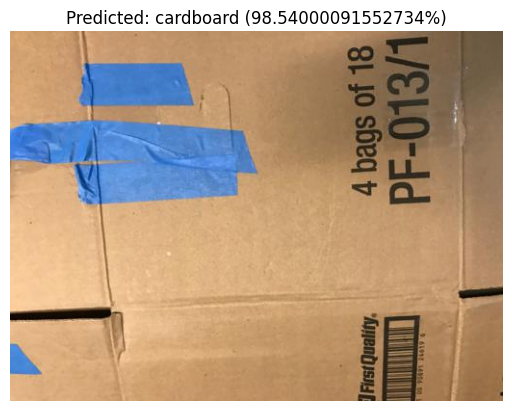

In [50]:
import matplotlib.pyplot as plt

img = cv2.imread(test_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title(predict_image(test_path))
plt.axis('off')
plt.show()


In [52]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.1 MB/s eta 0:00:00


📷 Enter path to waste image: /content/group-of-black-plastic-garbage-bag-isolated-on-transparent-background-file-png.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   

🧠 Predicted Class: metal
✅ Confidence: 42.58000183105469%


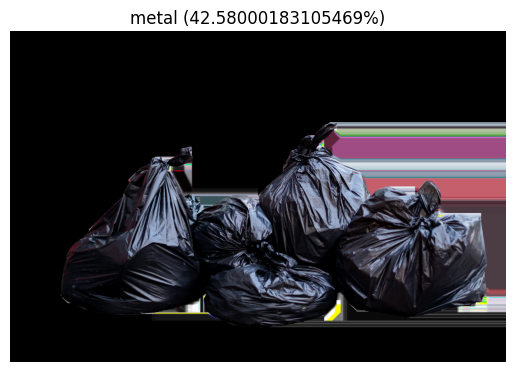

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import sys

# Load your trained model
model = load_model("trash_classifier.h5")

# Category labels (update if your dataset differs)
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
label_map = {i: cat for i, cat in enumerate(categories)}

# Predict function
def predict_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print("⚠️ Could not read the image. Please check the path.")
        return

    img_resized = cv2.resize(img, (128, 128))
    img_input = preprocess_input(img_resized)
    img_input = np.expand_dims(img_input, axis=0)

    prediction = model.predict(img_input)
    class_index = np.argmax(prediction)
    confidence = round(np.max(prediction) * 100, 2)

    predicted_label = label_map[class_index]

    # Show result
    print(f"\n🧠 Predicted Class: {predicted_label}")
    print(f"✅ Confidence: {confidence}%")

    # Display image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"{predicted_label} ({confidence}%)")
    plt.axis('off')
    plt.show()

# Example usage:
if __name__ == "__main__":
    image_path = input("📷 Enter path to waste image: ")
    predict_image(image_path)
